# Support points with Exponential Mechanism

### Procedure:


1. Given data $X = \{x_1, \ldots, x_M\}$ on space $\mathcal{D} \in [0, 1]^d$, find optimal support points $Y = \{y_1, \ldots, y_N\}$.
2. Using energy distance (with Lp norm) as the score function of the exponential mechanism, the sensitivity is $\Delta f = \frac{2 d^{1/p}(2N - 1)}{N^2}$. The exponential mechanism samples a new energy value $\tilde{e} \sim \mbox{Exp}(\frac{2\Delta f}{\alpha})$, where $\alpha$ is the privacy budget.
3. Let $\tilde{Y}$ be a copy of $Y$. Sample new $\tilde{Y}$ by Metropolis Hastings, using randomly perturbed versions of $\tilde{Y}$ as proposals, and using energy to compute the acceptance ratio.

---

 
Note: Exponential samples (i.e. energy distances) are larger with:
  - small privacy budget, $\alpha$
  - large sensitivity, $\Delta f$
  - large dimensionality, $d$
  - small energy exponent, $p$
  - small support point set, $N$.

___

# 0. Helper Functions

In [1]:
%matplotlib inline

import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pdb
from scipy.spatial.distance import pdist
import sys
import tensorflow as tf
import time

from data import load_balog_data
from sp_utils import (
    get_support_points,
    get_energy_sensitivity,
    energy,
    sample_sp_exp_mech,
    mixture_model_likelihood,
    sample_full_set_given_bandwidth)

matplotlib.rcParams.update({'font.size': 14})
plt.style.use('ggplot')
print(sys.version)
print(tf.__version__)

3.7.1 (default, Nov 28 2018, 11:55:14) 
[Clang 9.0.0 (clang-900.0.39.2)]
1.13.1


____

# 1. Global Config

Note: Exponential samples (i.e. energy distances) are smaller with:
  - large privacy budget, $\alpha$
  - small sensitivity, $\Delta f$
  - small dimensionality, $d$
  - large energy exponent, $p$
  - large support point set, $N$

In [2]:
# Set global constants.          # main1()
IS_TF = True                     # Boolean. Use TensorFlow rather than analytical gradients.
Y_INIT_OPTION = 'random'         # ['grid', 'random', 'radial']
MAX_ITER = 301                   # Num iterations in each support point optimization. [301]
LR = 1e-2                        # Energy optimization learning rate. [1e-2]

NUM_DATA = 200                   # Number of data points. [200]\
DIM = 2                          # Dimension of data. [2]
C = 10                           # Number of clusters in data. [10]
SIGMA_DATA = 0.03                # Bandwidth of data. [0.03]

NUM_SUPP = 10                    # Number of support points. [10]
ENERGY_POWER = 2                # Power for energy distance kernel. [2]

___

# 2. Load and Plot Data

In [3]:
# Load data.
np.random.seed(123)
x = load_balog_data(NUM_DATA, DIM, C, SIGMA_DATA, make_new=True, do_weighted=True)
#x = np.load('../../RKHS-private-database/data/mixture_of_Gaussians_N1000_D2_C10_SIG0.03.npz')['X_private']
print(x.shape)

Loaded M=200, DIM=2, SIG=0.03, C=10
(200, 2)


___

# 3. Run Support Point Optimization


STARTING RUN. is_tf: True, y_init: random, clip: bounds, wlb: False
  [*] Using TensorFlow optimization.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
  [*] Overall it/s: 0.0112


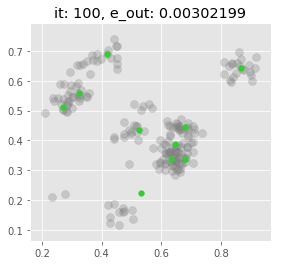

  [*] Overall it/s: 0.0108


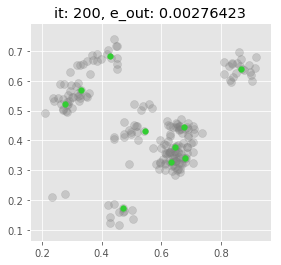

  [*] Overall it/s: 0.0108


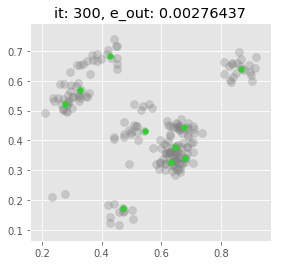

  [*] Time elapsed: 3.42


In [4]:
# Compute m support points on full set.
y_opt, e_opt = get_support_points(x, NUM_SUPP, MAX_ITER, LR, is_tf=IS_TF,
                                  power=ENERGY_POWER, y_init_option=Y_INIT_OPTION)  # NOTE: Power=2 to derive optimal SP.

#### Paper: Figure of support point optimization for variety of cluster sizes and counts.

Loaded M=200, DIM=2, SIG=0.02, C=5

STARTING RUN. is_tf: True, y_init: random, clip: bounds, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 2.19
Loaded M=200, DIM=2, SIG=0.02, C=10

STARTING RUN. is_tf: True, y_init: random, clip: bounds, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 2.48
Loaded M=200, DIM=2, SIG=0.02, C=30

STARTING RUN. is_tf: True, y_init: random, clip: bounds, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 2.34
Loaded M=200, DIM=2, SIG=0.04, C=5

STARTING RUN. is_tf: True, y_init: random, clip: bounds, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 2.06
Loaded M=200, DIM=2, SIG=0.04, C=10

STARTING RUN. is_tf: True, y_init: random, clip: bounds, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 2.19
Loaded M=200, DIM=2, SIG=0.04, C=30

STARTING RUN. is_tf: True, y_init: random, clip: bounds, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 1.90


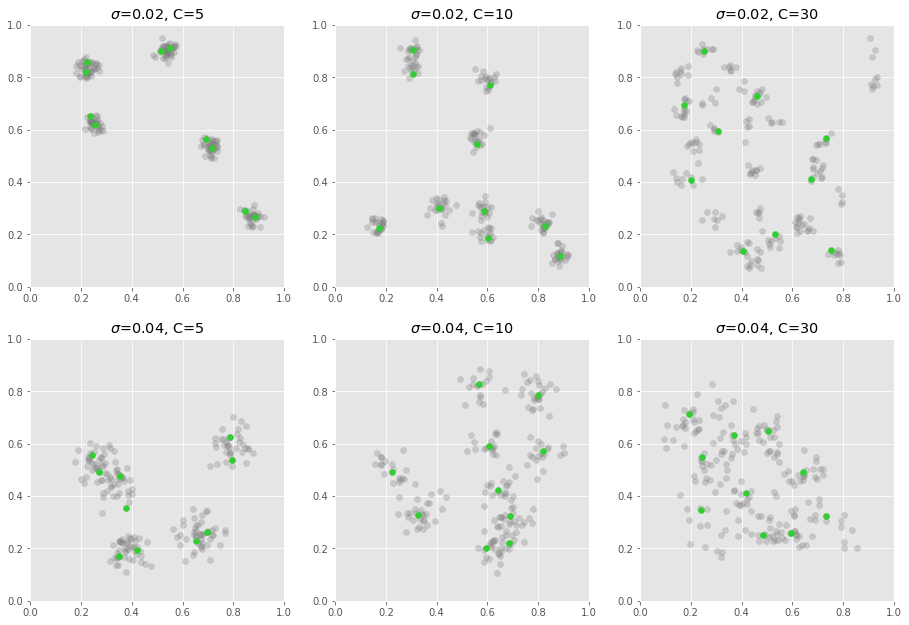

In [5]:
example_sigmas = [0.02, 0.04]
example_clusters = [5, 10, 30]
n_sig = len(example_sigmas)
n_clu = len(example_clusters)

fig, axs = plt.subplots(n_sig, n_clu, figsize=(5 * n_clu, 5 * n_sig))
for i, sigma in enumerate(example_sigmas):
    for j, cluster_count in enumerate(example_clusters):
        temp_data = load_balog_data(NUM_DATA, DIM, cluster_count, sigma, make_new=True,
                                    do_weighted=False)
        temp_y_opt, temp_e_opt = get_support_points(temp_data, NUM_SUPP, MAX_ITER,
                                                    LR, is_tf=IS_TF, power=ENERGY_POWER,
                                                    plot=False)

        axs[i, j].set_title('$\sigma$={}, C={}'.format(sigma, cluster_count))
        axs[i, j].scatter(temp_data[:, 0], temp_data[:, 1], c='gray', alpha=0.3)
        axs[i, j].scatter(temp_y_opt[:, 0], temp_y_opt[:, 1], c='limegreen', alpha=1)
        axs[i, j].set_xlim((0, 1))
        axs[i, j].set_ylim((0, 1))


plt.subplots_adjust(wspace=0.2, hspace=0.2,
                    bottom=0.1, top=0.9, left=0.1, right=0.9)
plt.savefig('../output/sp_optimization_various_clusterings.png')

___

## 4. Sample support points.

## 4.0 Sample support points with SP + Exponential Mechanism.

Exp(2 * U / alpha) = Exp(2 * 0.5374 / 5000.00) = Exp(0.00021496)

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.5374 / 5000.000) = Exp(0.00021496)

Running chain. Length=105000, Burn=5000, Thin=2000
Difference factor: 4652.02

acceptance_rate=0.00000000, step_size=0.01000000
Energy diff: 0.00026529


/Users/mauricediesendruck/privacy/mv_sp_privacy/src/sp_utils.py:436: RuntimeWarning: divide by zero encountered in power
  term1 = c1 * np.sum(pairwise_difs ** power, axis=2) ** (c1 - 1)


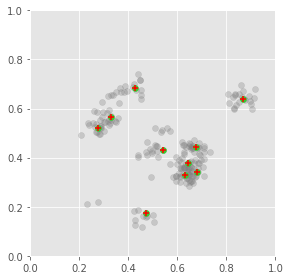

acceptance_rate=0.29330540, step_size=0.04201230
Energy diff: 0.00030619


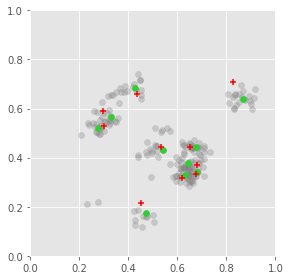

acceptance_rate=0.29689062, step_size=0.06564422
Energy diff: 0.00024667


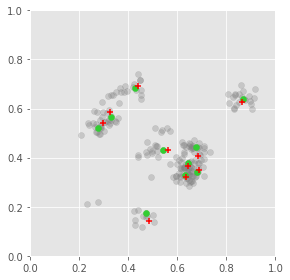

acceptance_rate=0.29786356, step_size=0.06564422
Energy diff: 0.00049750


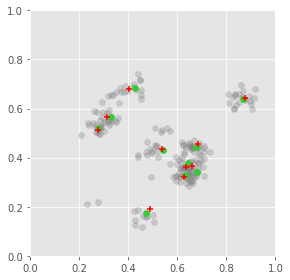

acceptance_rate=0.29932621, step_size=0.12821137
Energy diff: 0.00833375


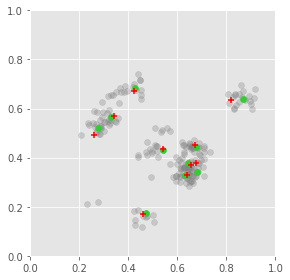

acceptance_rate=0.30186092, step_size=0.03636868
Energy diff: 0.00015780


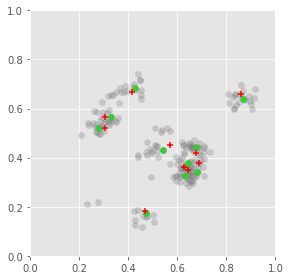

acceptance_rate=0.30199521, step_size=0.01683735
Energy diff: 0.00030422


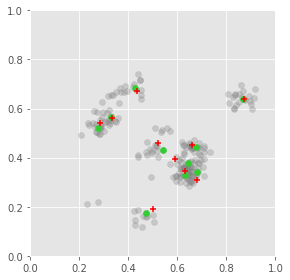

acceptance_rate=0.30081223, step_size=0.00811987
Energy diff: 0.00005459


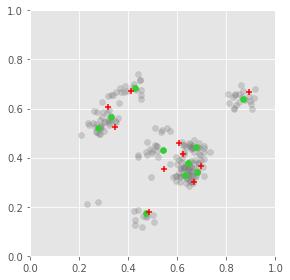

acceptance_rate=0.30053214, step_size=0.01268729
Energy diff: 0.00018463


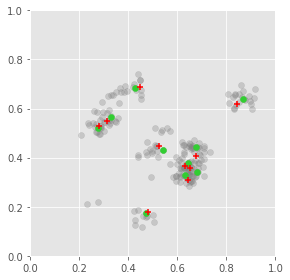

acceptance_rate=0.29964762, step_size=0.01101327
Energy diff: 0.00019644


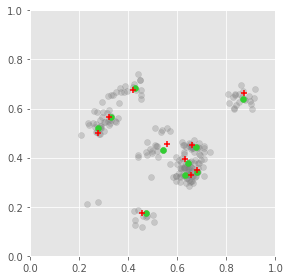

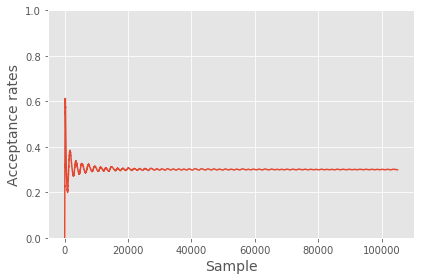

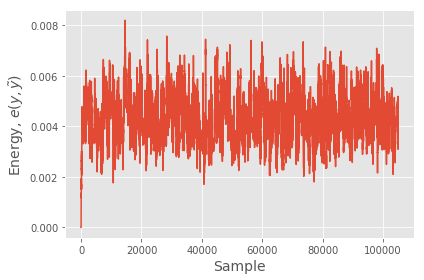

Acceptance rate: 0.299
percent steps that improved energy score: 0.149


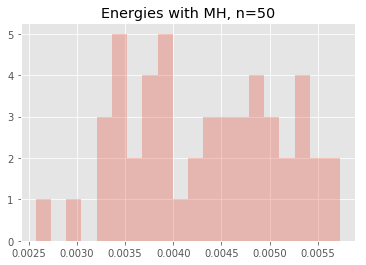

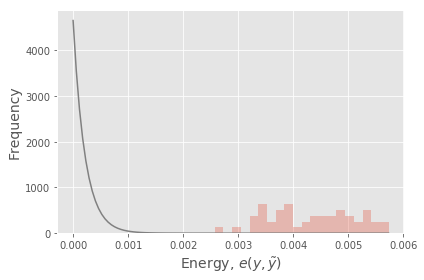

Exponential param: 0.00021496


In [6]:
# Sampling parameters.
NUM_Y_TILDES = 50
ALPHA = 5000  # 10000
save_dir = '../output'
# Define energy sensitivity for Exponential Mechanism.
energy_sensitivity = get_energy_sensitivity(x, NUM_SUPP, power=ENERGY_POWER)
print(('Exp(2 * U / alpha) = Exp(2 * {:.4f} / {:.2f}) '
       '= Exp({:.8f})').format(energy_sensitivity, ALPHA, 
                               2. * energy_sensitivity / ALPHA))

(y_tildes,
 energies,
 _) = sample_sp_exp_mech(e_opt, energy_sensitivity, x, y_opt, 'mh', NUM_Y_TILDES,
                         ALPHA, plot=1, save_dir=save_dir, power=ENERGY_POWER,
                         set_seed=True)

# PLOT RESULTS
#plt.title('Energies with MH, {} samples'.format(len(energies_mh)))
plt.hist(energies, bins=20, alpha=0.3, density=True, label='Samples')


# Compare to Exponential density.
p = exponential_param = 2. * energy_sensitivity / ALPHA
xs = np.linspace(0, np.max(energies), 100)
xs_dens = 1 / p * np.exp(-xs / p)
plt.plot(xs, xs_dens, c='gray', label='Exponential density')
plt.xlabel(r'Energy, $e(y, \tilde{y})$', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.tight_layout()
plt.savefig('../output/priv_sp_energies.png')
plt.show()
print('Exponential param: {:.8f}'.format(p))

## 4.1 Sample w/ ExpMech on Data Directly (NUM_DATA=NUM_SUPP)

In [7]:
"""
# Sampling parameters.
NUM_Y_TILDES = 21
ALPHA = 10000  # 10000
save_dir = '../output/balog_data_n_eq_m'
energy_sensitivity_num_data = get_energy_sensitivity(x, len(x), power=1)  # Note: Num supp = len(x).
print(('Exp(2 * U / alpha) = Exp(2 * {:.4f} / {:.2f}) '
   '= Exp({:.8f})').format(energy_sensitivity_num_data, ALPHA, 
                           2. * energy_sensitivity_num_data / ALPHA))

(y_tildes,
 energies,
 _) = sample_sp_exp_mech(e_opt, energy_sensitivity_num_data, x, x,  # NOTE: Instead of y_opt, use x.
                         'mh', NUM_Y_TILDES, ALPHA, plot=PLOT,
                         save_dir=save_dir,
                         power=ENERGY_POWER)

if PLOT:
    #plt.title('Energies with MH, {} samples'.format(len(energies_mh)))
    plt.hist(energies, bins=20, alpha=0.3, density=True, label='Samples')


    # Compare to Exponential density.
    p = exponential_param = 2. * energy_sensitivity_num_data / ALPHA
    xs = np.linspace(0, np.max(energies), 100)
    xs_dens = 1 / p * np.exp(-xs / p)
    plt.plot(xs, xs_dens, c='gray', label='Exponential density')
    plt.xlabel(r'Energy, $e(y, \tilde{y})$', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'priv_sp_energies.png'))
    plt.show()
    print('p: {}'.format(p))
"""

"\n# Sampling parameters.\nNUM_Y_TILDES = 21\nALPHA = 10000  # 10000\nsave_dir = '../output/balog_data_n_eq_m'\nenergy_sensitivity_num_data = get_energy_sensitivity(x, len(x), power=1)  # Note: Num supp = len(x).\nprint(('Exp(2 * U / alpha) = Exp(2 * {:.4f} / {:.2f}) '\n   '= Exp({:.8f})').format(energy_sensitivity_num_data, ALPHA, \n                           2. * energy_sensitivity_num_data / ALPHA))\n\n(y_tildes,\n energies,\n _) = sample_sp_exp_mech(e_opt, energy_sensitivity_num_data, x, x,  # NOTE: Instead of y_opt, use x.\n                         'mh', NUM_Y_TILDES, ALPHA, plot=PLOT,\n                         save_dir=save_dir,\n                         power=ENERGY_POWER)\n\nif PLOT:\n    #plt.title('Energies with MH, {} samples'.format(len(energies_mh)))\n    plt.hist(energies, bins=20, alpha=0.3, density=True, label='Samples')\n\n\n    # Compare to Exponential density.\n    p = exponential_param = 2. * energy_sensitivity_num_data / ALPHA\n    xs = np.linspace(0, np.max(energi

In [8]:
"""
# Compare to energies of e(y_opt, uniform)
baseline_energies = np.zeros(NUM_Y_TILDES)
for i in range(NUM_Y_TILDES):
    e_, _ = energy(y_opt, np.random.uniform(size=y_opt.shape))
    baseline_energies[i] = e_
plt.title('Energies with UNIFORM, n={}'.format(len(baseline_energies)))
plt.hist(baseline_energies, bins=20, alpha=0.3)
plt.show()
"""

"\n# Compare to energies of e(y_opt, uniform)\nbaseline_energies = np.zeros(NUM_Y_TILDES)\nfor i in range(NUM_Y_TILDES):\n    e_, _ = energy(y_opt, np.random.uniform(size=y_opt.shape))\n    baseline_energies[i] = e_\nplt.title('Energies with UNIFORM, n={}'.format(len(baseline_energies)))\nplt.hist(baseline_energies, bins=20, alpha=0.3)\nplt.show()\n"

#### Paper: Figure of private support point samples with various alphas.


Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.5374 / 1.000) = Exp(1.07480231)

Running chain. Length=7000, Burn=5000, Thin=2000
Difference factor: 0.93

acceptance_rate=1.00000000, step_size=0.01000000
Energy diff: 0.00026529
acceptance_rate=0.99429387, step_size=0.20033026
Energy diff: -0.00842041
acceptance_rate=0.99428979, step_size=0.20033026
Energy diff: 0.01048976
acceptance_rate=0.99476440, step_size=0.20033026
Energy diff: 0.00422100
acceptance_rate=0.99464477, step_size=0.20033026
Energy diff: -0.00273712
acceptance_rate=0.99485861, step_size=0.20033026
Energy diff: 0.00691010
acceptance_rate=0.99523923, step_size=0.20033026
Energy diff: -0.00392096
acceptance_rate=0.99571516, step_size=0.20033026
Energy diff: -0.00521745
acceptance_rate=0.99607213, step_size=0.20033026
Energy diff: -0.00109263
acceptance_rate=0.99634979, step_size=0.20033026
Energy diff: 0.02027307

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.5374 / 100.000) = Exp(0.010748

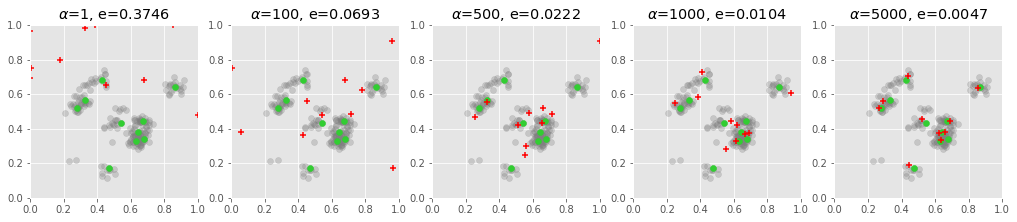

In [9]:
example_alphas = [1, 100, 500, 1000, 5000]
n_alp = len(example_alphas)
fig, axs = plt.subplots(1, n_alp, figsize=(3 * n_alp, 3))
energy_sensitivity = get_energy_sensitivity(x, NUM_SUPP, power=ENERGY_POWER)


for i, alpha in enumerate(example_alphas):
    (y_tildes,
     energies,
     energy_errors) = sample_sp_exp_mech(e_opt, energy_sensitivity,
                                         x, y_opt, 'mh',
                                         num_y_tildes=1,
                                         alpha=alpha,
                                         plot=False,
                                         power=ENERGY_POWER,
                                         set_seed=True)

    axs[i].set_title(r'$\alpha$={}, e={:.4f}'.format(alpha,
                                                     energies[0]))
    axs[i].scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3)
    axs[i].scatter(y_opt[:, 0], y_opt[:, 1], c='limegreen', alpha=1)
    axs[i].scatter(y_tildes[0, :, 0],
                   y_tildes[0, :, 1],
                   c='red', alpha=1,
                   marker='+')
    axs[i].set_xlim((0, 1))
    axs[i].set_ylim((0, 1))
        
plt.subplots_adjust(wspace=0.2, hspace=0.2,
                    bottom=0.1, top=0.9, left=0.05, right=0.95)
plt.savefig('../output/sp_various_alphas.png')
plt.show()

___

## 5. Expand to full data set.

## 5.0 KDE with pre-selected bandwidth.

#### Given privately sampled SP, expand them using KDE and pre-selected bandwidth.

In [10]:
ALPHA = 1000

energy_sensitivity = get_energy_sensitivity(x, NUM_SUPP, power=ENERGY_POWER)
energy_sensitivity_num_data = get_energy_sensitivity(x, len(x), power=ENERGY_POWER)  # Note: Num supp = len(x).

print(('Exp(2 * U / alpha) = Exp(2 * {:.4f} / {:.2f}) '
   '= Exp({:.8f})').format(energy_sensitivity_num_data, ALPHA, 
                           2. * energy_sensitivity_num_data / ALPHA))


FULL_SAMPLE_SIZE = NUM_DATA
PLOT = 1

Exp(2 * U / alpha) = Exp(2 * 0.0282 / 1000.00) = Exp(0.00005643)



Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.5374 / 1000.000) = Exp(0.00107480)

Running chain. Length=7000, Burn=5000, Thin=2000
Difference factor: 930.40

acceptance_rate=0.00000000, step_size=0.01000000
Energy diff: 0.00026529
acceptance_rate=0.37089872, step_size=0.20033026
Energy diff: 0.00381228
acceptance_rate=0.31263383, step_size=0.20033026
Energy diff: 0.00862664
acceptance_rate=0.30604474, step_size=0.14769950
Energy diff: 0.00048704
acceptance_rate=0.30453409, step_size=0.20033026
Energy diff: 0.00359766
acceptance_rate=0.30019994, step_size=0.20033026
Energy diff: 0.00183516
acceptance_rate=0.30230897, step_size=0.20033026
Energy diff: -0.00251964
acceptance_rate=0.30095899, step_size=0.20033026
Energy diff: 0.00245314
acceptance_rate=0.30690948, step_size=0.20033026
Energy diff: 0.00027397
acceptance_rate=0.30058721, step_size=0.09846633
Energy diff: 0.00053395

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.5374 / 1000.000) = Exp(0.0010

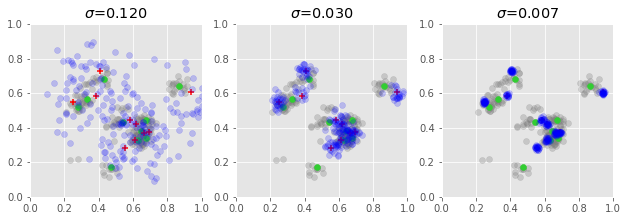

In [11]:
# Show data and y_tilde.
bandwidths = [SIGMA_DATA * 4, SIGMA_DATA, SIGMA_DATA / 4]
n_bw = len(bandwidths)

fig, axs = plt.subplots(1, n_bw, figsize=(3 * n_bw, 3))

for i, bw in enumerate(bandwidths):
    (y_tilde,
     y_tilde_upsampled,
     y_tilde_expansion) = sample_full_set_given_bandwidth(e_opt,
                                                          energy_sensitivity,
                                                          x, y_opt,
                                                          ALPHA, bw,
                                                          FULL_SAMPLE_SIZE, 
                                                          method='mh',
                                                          power=ENERGY_POWER,
                                                          set_seed=True)

    axs[i].set_title(r'$\sigma$={:.3f}'.format(bw))
    axs[i].scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3)
    axs[i].scatter(y_opt[:, 0], y_opt[:, 1], c='limegreen', alpha=1)
    axs[i].scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=1, marker='+')
    axs[i].scatter(y_tilde_expansion[:, 0], y_tilde_expansion[:, 1],
                   c='blue', alpha=0.2)
    axs[i].set_xlim((0, 1))
    axs[i].set_ylim((0, 1))
        
plt.subplots_adjust(wspace=0.2, hspace=0.2,
                    bottom=0.1, top=0.9, left=0.05, right=0.95)
plt.savefig('../output/kde_fixed_bandwidth.png')

## 5.1 KDE with DP-MLE bandwidth.

#### Compute likelihood over a range of bandwidths, and compute likelihood for each.

In [12]:
ALPHA = 1000
STEP_SIZE = 1e-2

PLOT = 1

In [13]:
ys, es, _ = sample_sp_exp_mech(e_opt, energy_sensitivity, x, y_opt,
                               'mh', num_y_tildes=1, alpha=ALPHA,
                               power=ENERGY_POWER, set_seed=True)
y_tilde = ys[0]

# Sample from mixture model centered on noisy support points.
choices = np.random.choice(range(len(y_tilde)), size=NUM_DATA)
y_tilde_upsampled = y_tilde[choices]


# Find optimal bandwidth using Maximum Likelihood.
BW_LOW = 0.0001
BW_HIGH = 0.05
NUM_BANDWIDTHS = 20
BW_RANGE = np.linspace(BW_HIGH, BW_LOW, NUM_BANDWIDTHS)

# Store bandwidth and likelihood pairs.
bw_lik = np.zeros((NUM_BANDWIDTHS, 2))

# Measure data likelihood under models centered on private support
# points, with a range of bandwidths.
for i, bw in enumerate(BW_RANGE): 
    lik, do_log = mixture_model_likelihood(x, y_tilde, bw)
    
    bw_lik[i] = [bw, lik]


# Print and plot all bandwidth-likelihood pairs.
bw_best, bw_best_lik = bw_lik[np.argmax(bw_lik, axis=0)[1]]
bw_worst, bw_worst_lik = bw_lik[np.argmin(bw_lik, axis=0)[1]]


Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.5374 / 1000.000) = Exp(0.00107480)

Running chain. Length=7000, Burn=5000, Thin=2000
Difference factor: 930.40

acceptance_rate=0.00000000, step_size=0.01000000
Energy diff: 0.00026529
acceptance_rate=0.37089872, step_size=0.20033026
Energy diff: 0.00381228
acceptance_rate=0.31263383, step_size=0.20033026
Energy diff: 0.00862664
acceptance_rate=0.30604474, step_size=0.14769950
Energy diff: 0.00048704
acceptance_rate=0.30453409, step_size=0.20033026
Energy diff: 0.00359766
acceptance_rate=0.30019994, step_size=0.20033026
Energy diff: 0.00183516
acceptance_rate=0.30230897, step_size=0.20033026
Energy diff: -0.00251964
acceptance_rate=0.30095899, step_size=0.20033026
Energy diff: 0.00245314
acceptance_rate=0.30690948, step_size=0.20033026
Energy diff: 0.00027397
acceptance_rate=0.30058721, step_size=0.09846633
Energy diff: 0.00053395
	 prod_liks=3.630e+38,
	 log_prod_liks=8.879e+01,
	 sum_lliks=8.879e+01


	 prod_liks=8.517e+

/Users/mauricediesendruck/privacy/mv_sp_privacy/src/sp_utils.py:916: RuntimeWarning: divide by zero encountered in log
  prod_liks, np.log(prod_liks), sum_lliks))
/Users/mauricediesendruck/privacy/mv_sp_privacy/src/sp_utils.py:917: RuntimeWarning: divide by zero encountered in log
  if prod_liks == 0. and np.log(prod_liks) == -np.Inf:


bw: 0.050000, llik: 8.88e+01
bw: 0.047374, llik: 9.42e+01
bw: 0.044747, llik: 9.99e+01
bw: 0.042121, llik: 1.06e+02
bw: 0.039495, llik: 1.12e+02
bw: 0.036868, llik: 1.19e+02
bw: 0.034242, llik: 1.25e+02
bw: 0.031616, llik: 1.33e+02
bw: 0.028989, llik: 1.41e+02
bw: 0.026363, llik: 1.49e+02
bw: 0.023737, llik: 1.59e+02
bw: 0.021111, llik: 1.69e+02
bw: 0.018484, llik: 1.81e+02
bw: 0.015858, llik: 1.94e+02
bw: 0.013232, llik: 2.10e+02
bw: 0.010605, llik: 2.28e+02
bw: 0.007979, llik: 2.48e+02
bw: 0.005353, llik: 2.67e+02
bw: 0.002726, llik: 2.54e+02
bw: 0.000100, llik: -4.81e+03


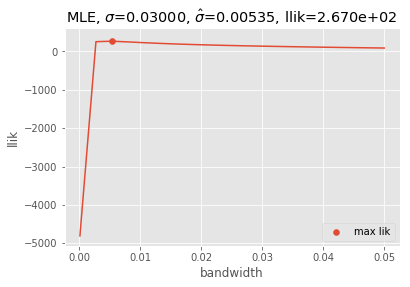

In [14]:
# Plot results for various bandwidths.
lik_str = 'llik' if do_log else 'lik'
for bw, lik in bw_lik:
    print('bw: {:.6f}, {}: {:.2e}'.format(bw, lik_str, lik))
plt.plot(bw_lik[:, 0], bw_lik[:, 1])
plt.scatter(bw_best, bw_best_lik, label='max lik')
plt.xlabel('bandwidth')
plt.ylabel(lik_str)
plt.title('MLE, $\sigma$={:.5f}, $\hat{{\sigma}}$={:.5f}, {}={:.3e}'.format(
    SIGMA_DATA, bw_best, lik_str, bw_best_lik))
plt.legend()
plt.savefig('../output/mle_bw_range.png')
plt.show()

#### Show samples with best and worst bandwidth.

	 prod_liks=4.119e+135,
	 log_prod_liks=3.123e+02,
	 sum_lliks=3.123e+02




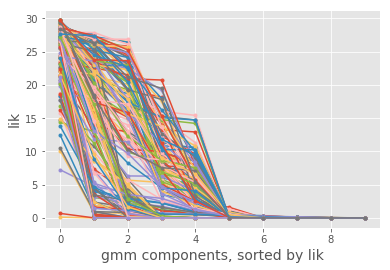

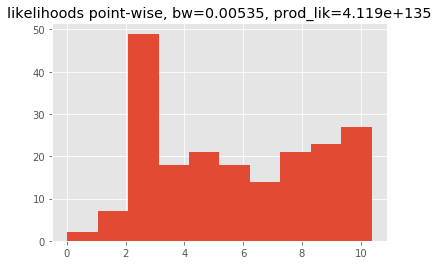

	 prod_liks=8.767e+115,
	 log_prod_liks=2.670e+02,
	 sum_lliks=2.670e+02




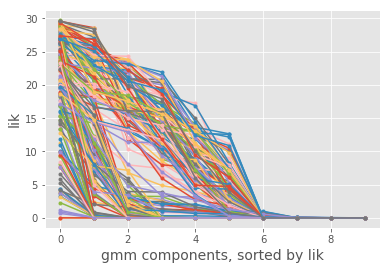

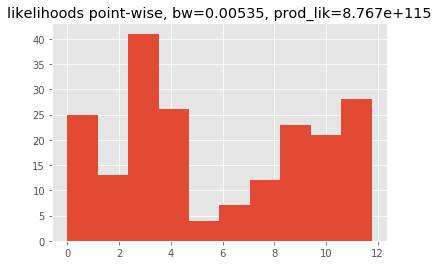

do_log: True
P(x | y_opt, bw_best): 3.12e+02
P(x | y_tilde, bw_best): 2.67e+02


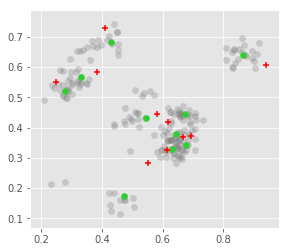

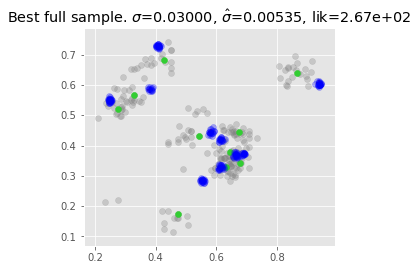

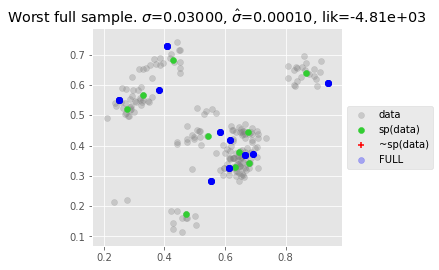

In [15]:
# Compare to likelihoods of data and optimal support points.
lik_y_opt, _ = mixture_model_likelihood(x, y_opt, bw_best,
                                        tag='Y_OPT, best bw: ',
                                        plot=True)
lik_y_tilde, _ = mixture_model_likelihood(x, y_tilde, bw_best,
                                          tag='Y_TILDE, best bw: ',
                                          plot=True)
print('do_log: {}'.format(do_log))
print('P(x | y_opt, bw_best): {:.2e}'.format(lik_y_opt))
print('P(x | y_tilde, bw_best): {:.2e}'.format(lik_y_tilde))


# Plot results.
new_sample_best = (
    y_tilde_upsampled + np.random.normal(0, bw_best,
                                         size=(FULL_SAMPLE_SIZE, x.shape[1])))
new_sample_worst = (
    y_tilde_upsampled + np.random.normal(0, bw_worst,
                                         size=(FULL_SAMPLE_SIZE, x.shape[1])))


if PLOT:
    # Plot with only data and support points.
    plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
    plt.scatter(y_opt[:, 0], y_opt[:, 1], c='limegreen', alpha=1,
                label='sp(data)')
    plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=1,
                label='~sp(data)', marker='+')
    #plt.title((r'Best full sample. $\sigma$={:.5f}, '
    #           '$\hat{{\sigma}}$={:.5f}, lik={:.2e}').format(SIGMA_DATA,
    #                                                         bw_best,
    #                                                         bw_best_lik))
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.savefig('../output/mle_pre_kde.png')
    plt.show()
    
    # Plot with best bandwidth.
    plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
    plt.scatter(y_opt[:, 0], y_opt[:, 1], c='limegreen', alpha=1,
                label='sp(data)')
    plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=1,
                label='~sp(data)', marker='+')
    plt.scatter(new_sample_best[:, 0], new_sample_best[:, 1], c='blue', alpha=0.3,
                label='FULL')

    plt.title((r'Best full sample. $\sigma$={:.5f}, '
               '$\hat{{\sigma}}$={:.5f}, lik={:.2e}').format(
        SIGMA_DATA, bw_best, bw_best_lik))
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.savefig('../output/mle_best_bw.png')
    plt.show()

    # Plot with worst bandwidth.
    plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
    plt.scatter(y_opt[:, 0], y_opt[:, 1], c='limegreen', alpha=1,
                label='sp(data)')
    plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=1,
                label='~sp(data)', marker='+')
    plt.scatter(new_sample_worst[:, 0], new_sample_worst[:, 1], c='blue',
                alpha=0.3, label='FULL')

    plt.title((r'Worst full sample. $\sigma$={:.5f}, '
                '$\hat{{\sigma}}$={:.5f}, lik={:.2e}').format(SIGMA_DATA,
                                                              bw_worst,
                                                              bw_worst_lik))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

#### Sample full synthetic set with DP sample of MLE bandwidth.

In this setting, for positive bandwidth $\sigma$, Gaussian data up to $4\sigma$ is bounded on $[0, 1]$ by restricting cluster centers to $[0 + 4\sigma, 1 - 4\sigma]$. The largest $\sigma$ that accommodates this bound is $\sigma = 1/8$. With sensitivity $\Delta f = 1/8$, we sample a DP bandwidth $\tilde{\sigma} \sim \mbox{Lap}(\sigma, \frac{1/8}{\alpha})$, and enforce a non-trivially small positive floor value $\delta$, with $\max(\tilde{\sigma}, \delta)$.


Best bw:       0.005353
raw DP bw:     0.005229
Corrected DP bw: 0.005229

Best bw:       0.005353
raw DP bw:     0.005286
Corrected DP bw: 0.005286

Best bw:       0.005353
raw DP bw:     0.005426
Corrected DP bw: 0.005426

Best bw:       0.005353
raw DP bw:     0.005078
Corrected DP bw: 0.005078


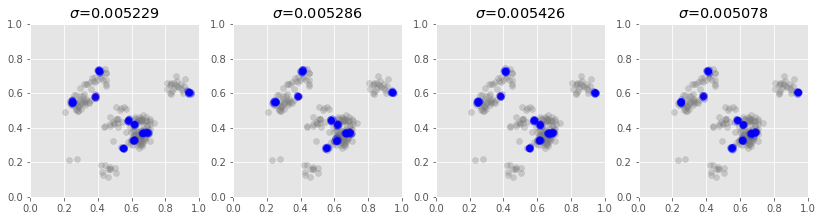

In [16]:
dp_bandwidths = []
floor = 1e-3
n_bw = 4

for _ in range(n_bw):
    dp_bandwidth_raw = bw_best + np.random.laplace(loc=0, scale=(1 / 8) / ALPHA)
    dp_bandwidth = np.max([dp_bandwidth_raw, floor])
    dp_bandwidths.append(dp_bandwidth)
    print('\nBest bw: {:>14.6f}\nraw DP bw: {:>12.6f}\nCorrected DP bw: {:>1.6f}'.format(
            bw_best, dp_bandwidth_raw, dp_bandwidth))



fig, axs = plt.subplots(1, n_bw, figsize=(3 * n_bw, 3))

for i, bw in enumerate(dp_bandwidths):
    y_tilde_expansion = (
        y_tilde_upsampled +
        np.random.normal(0, bw, size=(FULL_SAMPLE_SIZE, x.shape[1])))


    axs[i].set_title(r'$\sigma$={:.6f}'.format(bw))
    axs[i].scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3)
    axs[i].scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7)
    axs[i].scatter(y_tilde_expansion[:, 0], y_tilde_expansion[:, 1],
                   c='blue', alpha=0.2)
    axs[i].set_xlim((0, 1))
    axs[i].set_ylim((0, 1))
        
plt.subplots_adjust(wspace=0.2, hspace=0.2,
                    bottom=0.1, top=0.9, left=0.05, right=0.95)
plt.savefig('../output/mle_bw_dp.png')

## 5.3 Repeated draws of private support points.

#### Once with lower budget to show disperse output.


Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.5374 / 1000.000) = Exp(0.00107480)

Running chain. Length=7000, Burn=5000, Thin=2000
Difference factor: 930.40

acceptance_rate=0.00000000, step_size=0.01000000
Energy diff: 0.00014497
acceptance_rate=0.40656205, step_size=0.20033026
Energy diff: -0.00026082
acceptance_rate=0.32405425, step_size=0.20033026
Energy diff: 0.01051637
acceptance_rate=0.30366492, step_size=0.20033026
Energy diff: 0.00406551
acceptance_rate=0.30024991, step_size=0.20033026
Energy diff: 0.00425345
acceptance_rate=0.29905741, step_size=0.16026421
Energy diff: 0.00486288
acceptance_rate=0.30326113, step_size=0.09846633
Energy diff: 0.00016802
acceptance_rate=0.30299939, step_size=0.20033026
Energy diff: 0.00033001
acceptance_rate=0.29923228, step_size=0.12821137
Energy diff: 0.00471646
acceptance_rate=0.30312649, step_size=0.14179152
Energy diff: 0.00117635

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.5374 / 1000.000) = Exp(0.0010

acceptance_rate=0.38231098, step_size=0.20033026
Energy diff: 0.00200590
acceptance_rate=0.30049964, step_size=0.20033026
Energy diff: 0.00333667
acceptance_rate=0.30128510, step_size=0.12308291
Energy diff: 0.00098536
acceptance_rate=0.30953231, step_size=0.13611986
Energy diff: 0.00042980
acceptance_rate=0.30448443, step_size=0.20033026
Energy diff: 0.00935521
acceptance_rate=0.30111878, step_size=0.15385364
Energy diff: -0.00005773
acceptance_rate=0.30259131, step_size=0.13611986
Energy diff: 0.00474612
acceptance_rate=0.30298161, step_size=0.20033026
Energy diff: 0.00431525
acceptance_rate=0.30566577, step_size=0.20033026
Energy diff: -0.00357374

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.5374 / 1000.000) = Exp(0.00107480)

Running chain. Length=7000, Burn=5000, Thin=2000
Difference factor: 930.40

acceptance_rate=1.00000000, step_size=0.01000000
Energy diff: 0.00004144
acceptance_rate=0.37945792, step_size=0.20033026
Energy diff: -0.00018380
acceptance_rate=0.

acceptance_rate=0.29693076, step_size=0.16026421
Energy diff: 0.00381394
acceptance_rate=0.32317944, step_size=0.12043014
Energy diff: 0.00155737
acceptance_rate=0.30060693, step_size=0.20033026
Energy diff: 0.00158603
acceptance_rate=0.29791488, step_size=0.16026421
Energy diff: 0.00926311
acceptance_rate=0.30064270, step_size=0.18462437
Energy diff: 0.00728058
acceptance_rate=0.30442767, step_size=0.20033026
Energy diff: 0.00189805
acceptance_rate=0.30030352, step_size=0.19231705
Energy diff: 0.00637638
acceptance_rate=0.30280908, step_size=0.20033026
Energy diff: 0.00600104

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.5374 / 1000.000) = Exp(0.00107480)

Running chain. Length=7000, Burn=5000, Thin=2000
Difference factor: 930.40

acceptance_rate=1.00000000, step_size=0.01000000
Energy diff: 0.00034786
acceptance_rate=0.36804565, step_size=0.20033026
Energy diff: 0.00627907
acceptance_rate=0.29907209, step_size=0.14769950
Energy diff: 0.00045320
acceptance_rate=0.299

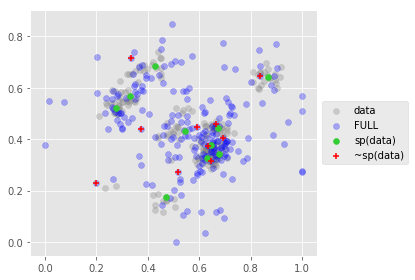

In [17]:
ALPHA = 1000

BANDWIDTH = SIGMA_DATA
NUM_REPEATS = int(NUM_DATA / NUM_SUPP) + 1
FULL_SAMPLE_SIZE = NUM_DATA

energy_sensitivity = get_energy_sensitivity(x, NUM_SUPP, power=ENERGY_POWER)


new_sample = []

for i in range(NUM_REPEATS):
    (y_tilde,
     y_tilde_upsampled,
     y_tilde_expansion) = sample_full_set_given_bandwidth(e_opt,
                                                          energy_sensitivity,
                                                          x, y_opt, ALPHA,
                                                          BANDWIDTH,
                                                          FULL_SAMPLE_SIZE,
                                                          method='mh',
                                                          power=ENERGY_POWER,
                                                          set_seed=False)
    new_sample.append(y_tilde)

new_sample = np.concatenate(new_sample)

print('\nConcatenating results, and plotting collection of samples as one.\n')
print('MH, alpha={}, repeats={}, budget={},\n n={}, bw={}'.format(
    ALPHA, NUM_REPEATS, ALPHA * float(NUM_REPEATS), len(new_sample),
    BANDWIDTH))

plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
plt.scatter(new_sample[:, 0], new_sample[:, 1], c='blue', alpha=0.3, label='FULL')
plt.scatter(y_opt[:, 0], y_opt[:, 1], c='limegreen', alpha=1, label='sp(data)')
plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=1, label='~sp(data)', marker='+')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.xlim(0, 1)
#plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.savefig('../output/repeated_samples_dispersed.png')
plt.show()

#### Once with higher budget to show focused output.


Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.5374 / 5000.000) = Exp(0.00021496)

Running chain. Length=7000, Burn=5000, Thin=2000
Difference factor: 4652.02

acceptance_rate=0.00000000, step_size=0.01000000
Energy diff: 0.00032093
acceptance_rate=0.28245364, step_size=0.00905970
Energy diff: -0.00001858
acceptance_rate=0.35974304, step_size=0.12924346
Energy diff: 0.00099695
acceptance_rate=0.25844836, step_size=0.03360984
Energy diff: 0.00014866
acceptance_rate=0.34594788, step_size=0.02525603
Energy diff: 0.00071384
acceptance_rate=0.30619823, step_size=0.20033026
Energy diff: 0.00541184
acceptance_rate=0.28612235, step_size=0.01376659
Energy diff: 0.00061599
acceptance_rate=0.32238319, step_size=0.05237090
Energy diff: 0.00284120
acceptance_rate=0.29119800, step_size=0.08205528
Energy diff: 0.00160551
acceptance_rate=0.31074433, step_size=0.01826970
Energy diff: 0.00076054

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.5374 / 5000.000) = Exp(0.000

acceptance_rate=0.36804565, step_size=0.00849347
Energy diff: 0.00000380
acceptance_rate=0.27765882, step_size=0.12821137
Energy diff: 0.00124471
acceptance_rate=0.31937173, step_size=0.01268729
Energy diff: 0.00017476
acceptance_rate=0.31453052, step_size=0.16289446
Energy diff: 0.00113722
acceptance_rate=0.27963439, step_size=0.01720824
Energy diff: -0.00031625
acceptance_rate=0.32706498, step_size=0.04364242
Energy diff: -0.00021984
acceptance_rate=0.29381759, step_size=0.10256909
Energy diff: 0.00204332
acceptance_rate=0.31119443, step_size=0.01522475
Energy diff: 0.00033498
acceptance_rate=0.30534836, step_size=0.19547335
Energy diff: 0.00616707

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.5374 / 5000.000) = Exp(0.00021496)

Running chain. Length=7000, Burn=5000, Thin=2000
Difference factor: 4652.02

acceptance_rate=0.00000000, step_size=0.01000000
Energy diff: 0.00019549
acceptance_rate=0.33951498, step_size=0.02087354
Energy diff: 0.00118598
acceptance_rate=0.

acceptance_rate=0.39186296, step_size=0.06422941
Energy diff: 0.00180068
acceptance_rate=0.27415516, step_size=0.08205528
Energy diff: 0.00140510
acceptance_rate=0.32024277, step_size=0.00811987
Energy diff: -0.00020996
acceptance_rate=0.33761782, step_size=0.10425245
Energy diff: 0.00095569
acceptance_rate=0.28850274, step_size=0.08205528
Energy diff: 0.00048266
acceptance_rate=0.30993675, step_size=0.01217980
Energy diff: 0.00012587
acceptance_rate=0.31065881, step_size=0.15637868
Energy diff: 0.00679631
acceptance_rate=0.28566894, step_size=0.02688787
Energy diff: 0.00020035

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.5374 / 5000.000) = Exp(0.00021496)

Running chain. Length=7000, Burn=5000, Thin=2000
Difference factor: 4652.02

acceptance_rate=1.00000000, step_size=0.01000000
Energy diff: 0.00019292
acceptance_rate=0.24679030, step_size=0.01546188
Energy diff: 0.00014836
acceptance_rate=0.34332620, step_size=0.08823021
Energy diff: 0.00120376
acceptance_rate=0.2

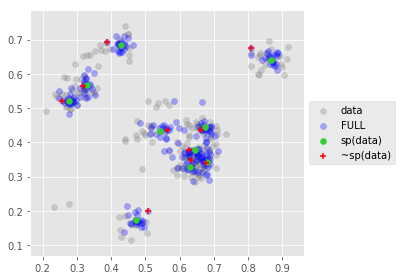

In [18]:
ALPHA = 5000

BANDWIDTH = SIGMA_DATA
NUM_REPEATS = int(NUM_DATA / NUM_SUPP) + 1
FULL_SAMPLE_SIZE = NUM_DATA

energy_sensitivity = get_energy_sensitivity(x, NUM_SUPP, power=ENERGY_POWER)


new_sample = []

for i in range(NUM_REPEATS):
    (y_tilde,
     y_tilde_upsampled,
     y_tilde_expansion) = sample_full_set_given_bandwidth(e_opt,
                                                          energy_sensitivity,
                                                          x, y_opt, ALPHA,
                                                          BANDWIDTH,
                                                          FULL_SAMPLE_SIZE,
                                                          method='mh',
                                                          power=ENERGY_POWER,
                                                          set_seed=False)
    new_sample.append(y_tilde)

new_sample = np.concatenate(new_sample)

print('\nConcatenating results, and plotting collection of samples as one.\n')
print('MH, alpha={}, repeats={}, budget={},\n n={}, bw={}'.format(
    ALPHA, NUM_REPEATS, ALPHA * float(NUM_REPEATS), len(new_sample),
    BANDWIDTH))

plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
plt.scatter(new_sample[:, 0], new_sample[:, 1], c='blue', alpha=0.3, label='FULL')
plt.scatter(y_opt[:, 0], y_opt[:, 1], c='limegreen', alpha=1, label='sp(data)')
plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=1, label='~sp(data)', marker='+')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.xlim(0, 1)
#plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.savefig('../output/repeated_samples_focused.png')
plt.show()

# End.